In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
import os
import sklearn
import time
import seaborn as sns
import pickle
import cv2
import shap

2025-11-14 16:52:37.622949: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-14 16:52:37.967581: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-14 16:52:40.109944: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
/home/le-cuong/Desktop/BTL_Machine_Learning/.venv/lib/python3.12/site-packages/tqdm/auto.py

In [2]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Data Exploration
- We chose the chest-x-ray datasets from Kaggle: https://www.kaggle.com/datasets/habibmrad1983/chestxray8-dataset

#### Split dataset into train dataset and test dataset

In [3]:
# Read csv-file
df = pd.read_csv("data/train-all.csv")
valid_df = pd.read_csv("data/valid-all.csv")
print(f'There are {df.shape[0]} rows and {df.shape[1]} columns in the train data frame')
print(df.head())

print("\n")

print(f'There are {valid_df.shape[0]} rows and {valid_df.shape[1]} columns in the train data frame')
print(valid_df.head())

There are 99316 rows and 16 columns in the train data frame
              Image  Atelectasis  Cardiomegaly  Consolidation  Edema  \
0  00000001_000.png            0             1              0      0   
1  00000001_001.png            0             1              0      0   
2  00000001_002.png            0             1              0      0   
3  00000002_000.png            0             0              0      0   
4  00000004_000.png            0             0              0      0   

   Effusion  Emphysema  Fibrosis  Hernia  Infiltration  Mass  Nodule  \
0         0          0         0       0             0     0       0   
1         0          1         0       0             0     0       0   
2         1          0         0       0             0     0       0   
3         0          0         0       0             0     0       0   
4         0          0         0       0             0     1       1   

   PatientId  Pleural_Thickening  Pneumonia  Pneumothorax  
0          1  

In [7]:
import pandas as pd
from sklearn.model_selection import GroupShuffleSplit

groups = df['PatientId']

test_size = 0.2

gss = GroupShuffleSplit(n_splits=1, test_size=test_size, random_state=42)

train_idx, test_idx = next(gss.split(df, groups=groups))

# Tạo DataFrame 'train' và 'test' từ các chỉ số (indices)
train_df = df.iloc[train_idx]
test_df = df.iloc[test_idx]

# --- (Phần còn lại của code bạn giữ nguyên) ---
print(f"Toàn bộ: {len(df)} ảnh")
print(f"Train:   {len(train_df)} ảnh ({len(train_df)/len(df):.1%})")
print(f"Test:    {len(test_df)} ảnh ({len(test_df)/len(df):.1%})")

train_df.to_csv('data/train.csv', index=False)
test_df.to_csv('data/test.csv', index=False)

print("\nĐã lưu thành công 2 files: train.csv, test.csv")

Toàn bộ: 99316 ảnh
Train:   79774 ảnh (80.3%)
Test:    19542 ảnh (19.7%)

Đã lưu thành công 2 files: train.csv, test.csv


#### Prevent Data Leakage

In [8]:
def check_for_leakage(df1, df2, patient_col):
    """
    Return True if there any patients are in both df1 and df2.

    Args:
        df1 (dataframe): dataframe describing first dataset
        df2 (dataframe): dataframe describing second dataset
        patient_col (str): string name of column with patient IDs
    
    Returns:
        leakage (bool): True if there is leakage, otherwise False
    """

    df1_patients_unique = set(df1[patient_col])
    df2_patients_unique = set(df2[patient_col])

    patients_in_both_groups = list(df1_patients_unique.intersection(df2_patients_unique))

    leakage = len(patients_in_both_groups) > 0

    return leakage

In [10]:
print("leakage between train and test: {}".format(check_for_leakage(train_df, test_df, 'PatientId')))
print("leakage between valid and test: {}".format(check_for_leakage(valid_df, test_df, 'PatientId')))

leakage between train and test: False
leakage between valid and test: False


#### Explore data labels

In [26]:
columns = train_df.keys()
columns = list(columns)
print(columns)

['Image', 'Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'PatientId', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


In [27]:
# Remove unnecessary elements
columns.remove('Image')
columns.remove('PatientId')

print(f"There are {len(columns)} columns of labels for these conditions: {columns}")

for column in columns:
    print(f"The class {column} has {train_df[column].sum()} samples")

There are 14 columns of labels for these conditions: ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']
The class Atelectasis has 8240 samples
The class Cardiomegaly has 1837 samples
The class Consolidation has 3133 samples
The class Edema has 1502 samples
The class Effusion has 9169 samples
The class Emphysema has 1624 samples
The class Fibrosis has 1179 samples
The class Hernia has 84 samples
The class Infiltration has 13763 samples
The class Mass has 3972 samples
The class Nodule has 4473 samples
The class Pleural_Thickening has 2264 samples
The class Pneumonia has 936 samples
The class Pneumothorax has 3537 samples


#### Data Visualization

Display Random Images


FileNotFoundError: [Errno 2] No such file or directory: 'data/images-all/00028534_001.png'

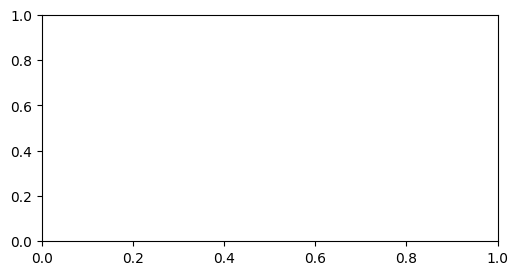

In [29]:
images = train_df['Image'].values

# Extract 9 random images from it
random_images = [np.random.choice(images) for i in range(1)]

# Location of the image dir
img_dir = 'data/images-all/'
print('Display Random Images')

# Adjust the size of images
plt.figure(figsize=(20, 10))

for i in range(1):
    plt.subplot(3, 3, i + 1)
    img = plt.imread(os.path.join(img_dir, random_images[i]))
    plt.imshow(img, cmap='gray')
    plt.axis('off')

plt.tight_layout()